In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras as K

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-11 10:39:37.804728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import splitfolders

# Diviser le dossier 'Images' avec un ratio de 90% pour l'entraînement (incluant la validation) et 10% pour les tests
splitfolders.ratio("../Images", output="../data_split", seed=42, ratio=(.9, .1), group_prefix=None) 


Copying files: 20580 files [00:13, 1512.29 files/s]


Found 14816 images belonging to 120 classes.
Found 3654 images belonging to 120 classes.


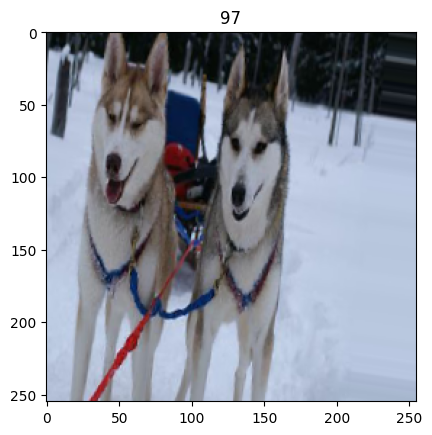

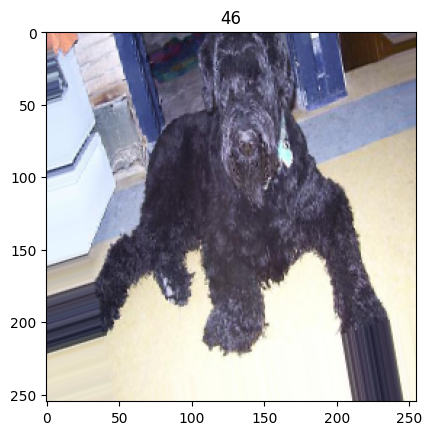

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras import optimizers
from keras import backend as K

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # Réserver 20% des données pour la validation

# Créer le générateur pour l'entraînement
train_generator = train_datagen.flow_from_directory(
    "../data_split/train",
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Utiliser la partie 'training' du dataset

# Créer le générateur pour la validation
validation_generator = train_datagen.flow_from_directory(
    "../data_split/train",
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    subset='validation') 

# Visualisation de deux images du générateur
x,y = train_generator.next()

for i in range(0,2):
    image = x[i]
    plt.imshow(image)
    plt.title(y[i].argmax())
    plt.show()

/var/folders/jv/jdrknp2n48x66n75cd2pdr0w0000gn/T/ipykernel_22457/1651753028.py:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-12-11 10:41:28.915233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


463/463 [==============================] - ETA: 0s - loss: 1.9971 - accuracy: 0.5402 

2023-12-11 14:47:55.296444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.76411, saving model to test.h5
463/463 [==============================] - 15524s 33s/step - loss: 1.9971 - accuracy: 0.5402 - val_loss: 0.7641 - val_accuracy: 0.7761 - lr: 1.0000e-04


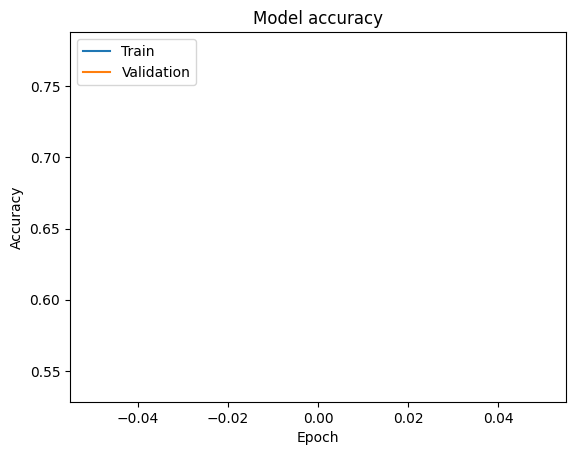

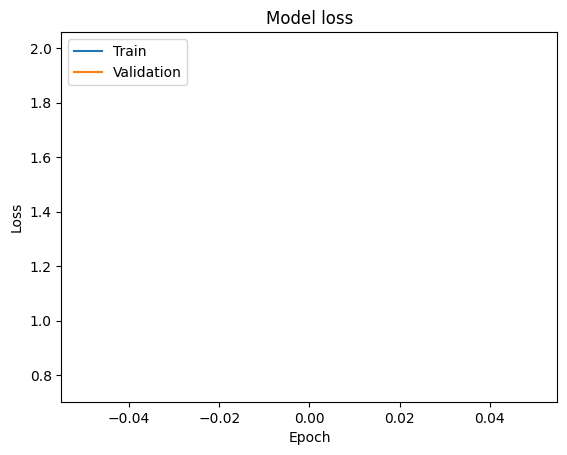

In [4]:
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import matplotlib.pyplot as plt


# Charger le modèle Xception pré-entraîné
base_model = Xception(weights='imagenet', include_top=False)

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Ajouter Global Average Pooling pour réduire la dimensionnalité
x = Dense(1024, activation='relu')(x)  # Ajouter une couche Dense pour l'apprentissage des caractéristiques
x = Dropout(0.5)(x)  # Ajouter une couche de dropout pour réduire le surapprentissage
x = Dense(1024, activation='relu')(x)  # Ajouter une couche Dense pour l'apprentissage des caractéristiques
predictions = Dense(120, activation='softmax')(x)  # Couche de sortie pour 120 classes

# Configurer les callbacks
checkpoint = ModelCheckpoint("test.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


# Définir le learning rate
learning_rate = 0.0001  

# Créer l'instance de l'optimiseur avec le learning rate spécifié
optimizer = Adam(learning_rate=learning_rate)

# Compiler le modèle avec l'optimiseur configuré
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    callbacks=[checkpoint, early, lr_scheduler])

# Tracer la précision et la perte
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Sauvegarder le modèle
model.save('test_final.h5')


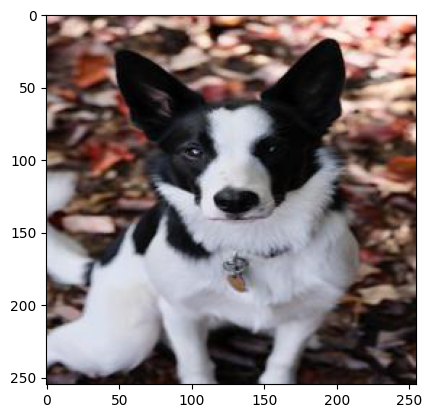

1/1 [==============================] - 1s 1s/step
[112  76   7]
[0.454863   0.18531126 0.08068095]
[112]
112
{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Stafford

In [3]:
from PIL import Image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Change la taille de l'image IMG_6301 pour qu'elle soit de 255x255
img = Image.open('../../../border.jpeg')
img = img.resize((255, 255))
img.save('../../../border_resized.jpg')  # Il est préférable de sauvegarder la nouvelle image avec un nom différent pour éviter de perdre l'original.

# Predis avec le modèle et affiche le résultat
from keras.preprocessing import image
from keras.utils import load_img
from keras.utils import img_to_array
import numpy as np  

#Charge le modele 
model = load_model('test_final.h5')

img_path = '../../../border_resized.jpg'  
#Affiche l'image
image = Image.open(img_path)
plt.imshow(image)
plt.show()

img = load_img(img_path, target_size=(255, 255))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.

result = model.predict(img)
#Affiche les 3 classes les plus probables et leur probabilité
print(np.argsort(result, axis=1)[0][::-1][:3])
print(np.sort(result, axis=1)[0][::-1][:3])


print(np.argmax(result, axis=1))
print(np.argmax(result, axis=1)[0])
print(train_generator.class_indices)
print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(result, axis=1)[0])])



In [4]:
# Test le model sur le dossier de test
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

## Charger le modèle
model = load_model('test_final.h5')  

# Créer le générateur pour les tests
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "../data_split/val",  
    target_size=(255, 255), 
    batch_size=32,
    class_mode='categorical',
    shuffle=False) 


test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

# Évaluer le modèle
scores = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Accuracy sur le test set: ", scores[1])

# Prédire les classes
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_class_indices = np.argmax(predictions, axis=1)

# Afficher les classes prédictes
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_labels = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Predictions": predictions_labels})


Found 2110 images belonging to 120 classes.


2023-12-13 11:00:40.551587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 448s 7s/step - loss: 0.6889 - accuracy: 0.7991
Accuracy sur le test set:  0.7990521192550659


2023-12-13 11:08:08.749583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


66/66 [==============================] - 511s 8s/step


In [14]:
print(results.head(10))

                                  Filename            Predictions
0  n02085620-Chihuahua/n02085620_11238.jpg    n02085620-Chihuahua
1  n02085620-Chihuahua/n02085620_11258.jpg    n02085620-Chihuahua
2  n02085620-Chihuahua/n02085620_11337.jpg    n02085620-Chihuahua
3   n02085620-Chihuahua/n02085620_1321.jpg    n02085620-Chihuahua
4  n02085620-Chihuahua/n02085620_13383.jpg    n02085620-Chihuahua
5  n02085620-Chihuahua/n02085620_14252.jpg    n02085620-Chihuahua
6  n02085620-Chihuahua/n02085620_14516.jpg  n02087046-toy_terrier
7   n02085620-Chihuahua/n02085620_1620.jpg  n02087046-toy_terrier
8   n02085620-Chihuahua/n02085620_2793.jpg    n02085620-Chihuahua
9   n02085620-Chihuahua/n02085620_2887.jpg    n02085620-Chihuahua


In [6]:
import coremltools as ct
import tensorflow as tf

# Charger le modèle Keras
model = tf.keras.models.load_model('test_final.h5')

# Définir les informations d'entrée
input_image = ct.ImageType(shape=(1, 255, 255, 3),  # Format Batch x Height x Width x Channels
                           scale=1/255.0)  # Normalisation : les pixels sont divisés par 255

# Convertir le modèle
mlmodel = ct.convert(model, inputs=[input_image])

# Sauvegarder le modèle converti
mlmodel.save('MonModelTest.mlmodel')


TensorFlow version 2.12.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.10.0 is the most recent version that has been tested.
2023-12-13 11:17:31.724964: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-12-13 11:17:33.321191: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-12-13 11:17:34.941453: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-12-13 11:17:36.096966: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
Translating MIL =

In [7]:


# Charger le modèle Core ML
model_path = 'MonModelTest.mlmodel'  # Chemin vers votre modèle Core ML
mlmodel = ct.models.MLModel(model_path)


In [11]:
from PIL import Image

# Charger une image
img_path = '../../../border.jpeg'  # Chemin vers une image de test
image = Image.open(img_path)
image = image.resize((255, 255))  # Redimensionner l'image

# Préparer l'entrée pour le modèle Core ML
input_dict = {'input_1': image}  # 'input_1' doit correspondre au nom de l'entrée du modèle

# Faire une prédiction
output = mlmodel.predict(input_dict)

print(output)  # Affiche les résultats de la prédiction


{'Identity': array([[1.8432617e-02, 6.7043304e-04, 6.4551830e-05, 3.7527084e-04,
        1.2559891e-03, 1.6129017e-04, 5.4290771e-02, 4.4769287e-02,
        3.7741661e-04, 1.5366077e-04, 1.5366077e-04, 6.7758560e-04,
        1.9812584e-04, 9.5796585e-04, 5.7399273e-05, 3.7121773e-04,
        3.8766861e-04, 2.4068356e-04, 2.7027130e-03, 3.3521652e-04,
        4.7135353e-04, 5.4264069e-04, 2.9144287e-03, 4.7950745e-03,
        7.7605247e-05, 8.0585480e-04, 5.4550171e-04, 1.9490719e-04,
        7.3051453e-04, 2.8915405e-03, 3.7741661e-04, 2.1493435e-04,
        2.9253960e-04, 1.2025833e-03, 5.9795380e-04, 1.8167496e-04,
        4.7636032e-04, 3.3140182e-04, 3.2782555e-04, 1.8370152e-04,
        3.4785271e-04, 1.3475418e-03, 1.3113022e-03, 7.3552132e-05,
        6.8778992e-03, 7.9727173e-04, 3.8552284e-04, 1.8157959e-03,
        1.7805099e-03, 3.8981438e-04, 1.2903214e-03, 2.1958351e-04,
        4.7898293e-04, 1.5866756e-04, 6.4516068e-04, 2.4199486e-04,
        1.2559891e-03, 1.6450882e-0

In [9]:
import numpy as np

# Préparer l'entrée pour le modèle Core ML
input_dict = {'input_1': image}  # 'input_1' doit correspondre au nom de l'entrée du modèle

# Faire une prédiction
output = mlmodel.predict(input_dict)

probabilities = output['Identity'].flatten()

# Trier les indices en fonction des probabilités, dans l'ordre décroissant
sorted_indices = np.argsort(probabilities)[::-1]

# Afficher les 3 classes les plus probables
top_3_indices = sorted_indices[:3]

for index in top_3_indices:
    print(f"Classe {index}: Probabilité = {probabilities[index]:.2f}")

Classe 112: Probabilité = 0.41
Classe 76: Probabilité = 0.21
Classe 81: Probabilité = 0.06
